In [1]:
# 导入相关库
import typing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

In [2]:
# 定义超参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}")

from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./data/Cora', name='Cora')
graph = dataset[0].to(device)

device : cuda


In [3]:
print(graph)
print(f"train num : {graph.train_mask.sum()}")
print(f"val num : {graph.val_mask.sum()}")
print(f"test num : {graph.test_mask.sum()}")
print(f"num classes : {dataset.num_classes}")

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
train num : 140
val num : 500
test num : 1000
num classes : 7


In [4]:
in_channels = graph.x.shape[1]
hidden_channels = 16 # 隐藏层维度
out_channels = dataset.num_classes

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, x : Data.x, edge_index : Data.edge_index):
        # x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [5]:
epochs = 256 # 训练轮数
lr = 0.01 # 学习率
val_record_interval = 8

In [6]:
model = torch_geometric.nn.GCN(
    in_channels=in_channels, 
    hidden_channels=hidden_channels, 
    out_channels=out_channels, 
    num_layers=4, 
    dropout=5e-4,
    ).to(device)
# model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)
loss_func = nn.NLLLoss()
m = nn.LogSoftmax(dim=1)

In [7]:
# def train_step(
#     model : torch.nn.Module,
#     data : Data,
#     optimizer : torch.optim.Optimizer,
#     loss_fn : torch.nn.functional
# ) -> typing.Tuple[float, float]:
#     model.train()
#     optimizer.zero_grad()
#     mask = data.train_mask
#     logits = model(data.x, data.edge_index)[mask]
#     preds = logits.argmax(dim=1)
#     y = data.y[mask]
#     loss = loss_fn(logits, y)
    
#     acc = 

In [8]:
loss_x = [e for e in range(epochs)]
loss_record = []
acc_x = [e for e in range(epochs) if e%val_record_interval == 0]
acc_record = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(graph.x, graph.edge_index)
    # print(out.shape)
    loss = loss_func(m(out[graph.train_mask]), graph.y[graph.train_mask])
    loss_record.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % val_record_interval == 0:
        model.eval()
        _, pred = model(graph.x, graph.edge_index).max(dim=1)
        correct = float(pred[graph.val_mask].eq(graph.y[graph.val_mask]).sum().item())
        acc = correct / graph.val_mask.sum().item()
        acc_record.append(acc)

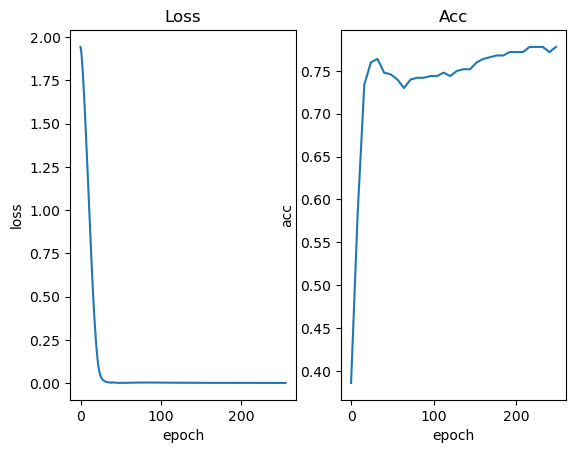

In [9]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(loss_x, loss_record)
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(acc_x, acc_record)
plt.title('Acc')
plt.xlabel('epoch')
plt.ylabel('acc')

plt.show()

In [10]:
model.eval()
_, pred = model(graph.x, graph.edge_index).max(dim=1)
correct = float(pred[graph.test_mask].eq(graph.y[graph.test_mask]).sum().item())
acc = correct / graph.test_mask.sum().item()
# print(graph.test_mask.sum().item())
print(f"acc : {acc}")

acc : 0.774
